## Introduction

In this notebook we use data from https://github.com/alexeygrigorev/clothing-dataset and make a Reverse Image Search to find 5 most similar images for a given image (random image from 10 different classes). We use pre-trained ResNet50V2 model, then fine-tune it and add some augmentations for the data and compare results of different models (in this notebook we load saved models, training of models provided in separate notebook). Finally, we calculate results on the test data set with our best model. In addition, we show the reduction of feature vectors possibility to make our Reverse Image Search faster. 

### Setup:

In [50]:
import pickle
import numpy as np
from numpy.linalg import norm
import os
import random
import statistics
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.applications import ResNet50V2
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Feature extraction

First, load the ResNet-50V2 model without top classification layers:

In [2]:
base_model = ResNet50V2(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3), pooling='max')

Define a function that takes an image path, loads the image, resizes it to proper dimensions supported by ResNet-50V2, extracts the features and then normalizes them:

In [3]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = expanded_img_array/255
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

If we want to extract features on the entire data set, we need to get all the filenames:

In [4]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

# function that returns a file list of image names for given directory:
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

We also create a function that extracts and saves filenames and feature vectors for given directory of images and given model:

In [5]:
def save_to_pickle(root_dir, model, features_name_to_save, filenames_name_to_save):
    filenames = sorted(get_file_list(root_dir))

    feature_list = []
    for i in range(len(filenames)):
        feature_list.append(extract_features(filenames[i], model))

    pickle.dump(feature_list, open(features_name_to_save, 'wb'))
    pickle.dump(filenames, open(filenames_name_to_save,'wb'))

We save our train data set features to pickle file so that we can reuse them without recalculating:

In [6]:
save_to_pickle('data\\train', base_model, 'pickles/features-fashion_small.pickle', 'pickles/filenames-fashion_small.pickle')

## Similarity search

First, load saved filenames and features:

In [7]:
filenames = pickle.load(open('pickles/filenames-fashion_small.pickle', 'rb'))
feature_list = pickle.load(open('pickles/features-fashion_small.pickle', 'rb'))

Create a Nearest Neighbors model (we will reuse it later with metric="cosine" for the results comparison)

In [8]:
knn = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')

Then, fit the knn model to get nearest neighbours and distances between features:

In [9]:
neighbors = knn.fit(feature_list)

# distances and indices of nearest neighbors for the first image in train dataset:
distances, indices = neighbors.kneighbors([feature_list[0]])

Let's plot the first image in filenames:

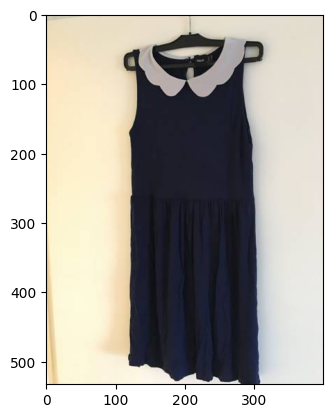

In [10]:
plt.imshow(mpimg.imread(filenames[0]))

We can also plot the nearest neighbour of first image, which is, of course - a duplicate:

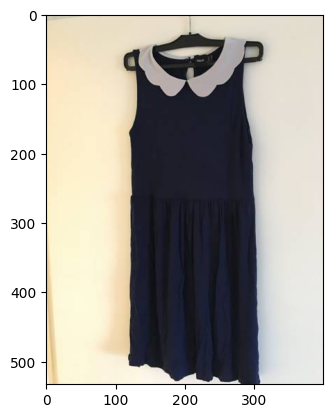

In [11]:
plt.imshow(mpimg.imread(filenames[indices[0][0]]))

We can also check distances of nearest neighbours:

In [12]:
for i in range(5):
    print(distances[0][i])

0.0
0.6323437779763312
0.6787452743955888
0.7001673694179682
0.7039929860453814


Let's plot the real first most similar image for the first image:

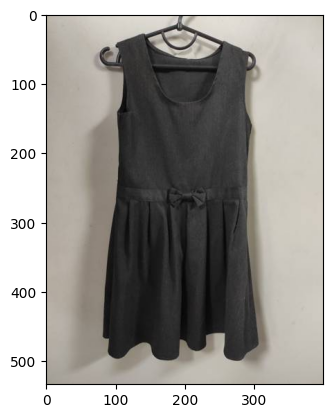

In [13]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]))

We can now make a function that plots several images with their nearest neighbors.
This function is suitable for both: train and validation (test) data sets.
The difference between plotting train and validation (test) data sets is that in the first case we take all the images from the same data set, while in the second one we take several random images from validation data set and plot most similar images from train data set (train+validation). 

In [14]:
# function that plots random num_images images and their nearest neighbors for given list of filenames and features.
# we reuse the same knn object from previous cells, num_similar can't be more than 5:
def plot_images(random_filenames, random_features, knn_filenames, knn_features, num_images, num_similar):
    fig, axs = plt.subplots(num_images, num_similar + 1, figsize=(15, 15))
    for i in range(num_images):
        random_image_index = random.randint(0, len(random_filenames) - 1)
        neighbors = knn.fit(knn_features)
        distances, indices = neighbors.kneighbors([random_features[random_image_index]])
        if random_filenames == knn_filenames:
            # don't take the first closest image as it will be the same image
            similar_image_paths = [random_filenames[random_image_index]] + [knn_filenames[indices[0][i]] for i in range(1,num_similar + 1)]
        else:
            similar_image_paths = [random_filenames[random_image_index]] + [knn_filenames[indices[0][i]] for i in range(0,num_similar)]
        for j in range(num_similar + 1):
            img = mpimg.imread(similar_image_paths[j])
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title('Query Image' + '\n' + similar_image_paths[j].split('\\')[1] + '/' + 
                                    similar_image_paths[j].split('\\')[2])
            else:
                axs[i, j].set_title('Similar Image' + '\n' + similar_image_paths[j].split('\\')[1] + '/' + 
                                    similar_image_paths[j].split('\\')[2]+'\n'+f'Distance: {round(distances[0][j],4)}' )
    
    plt.show()

Now we can use the plot function and plot 4 random images from the train set and 4 nearest neighbors for each image (except the first one, which is the same image):

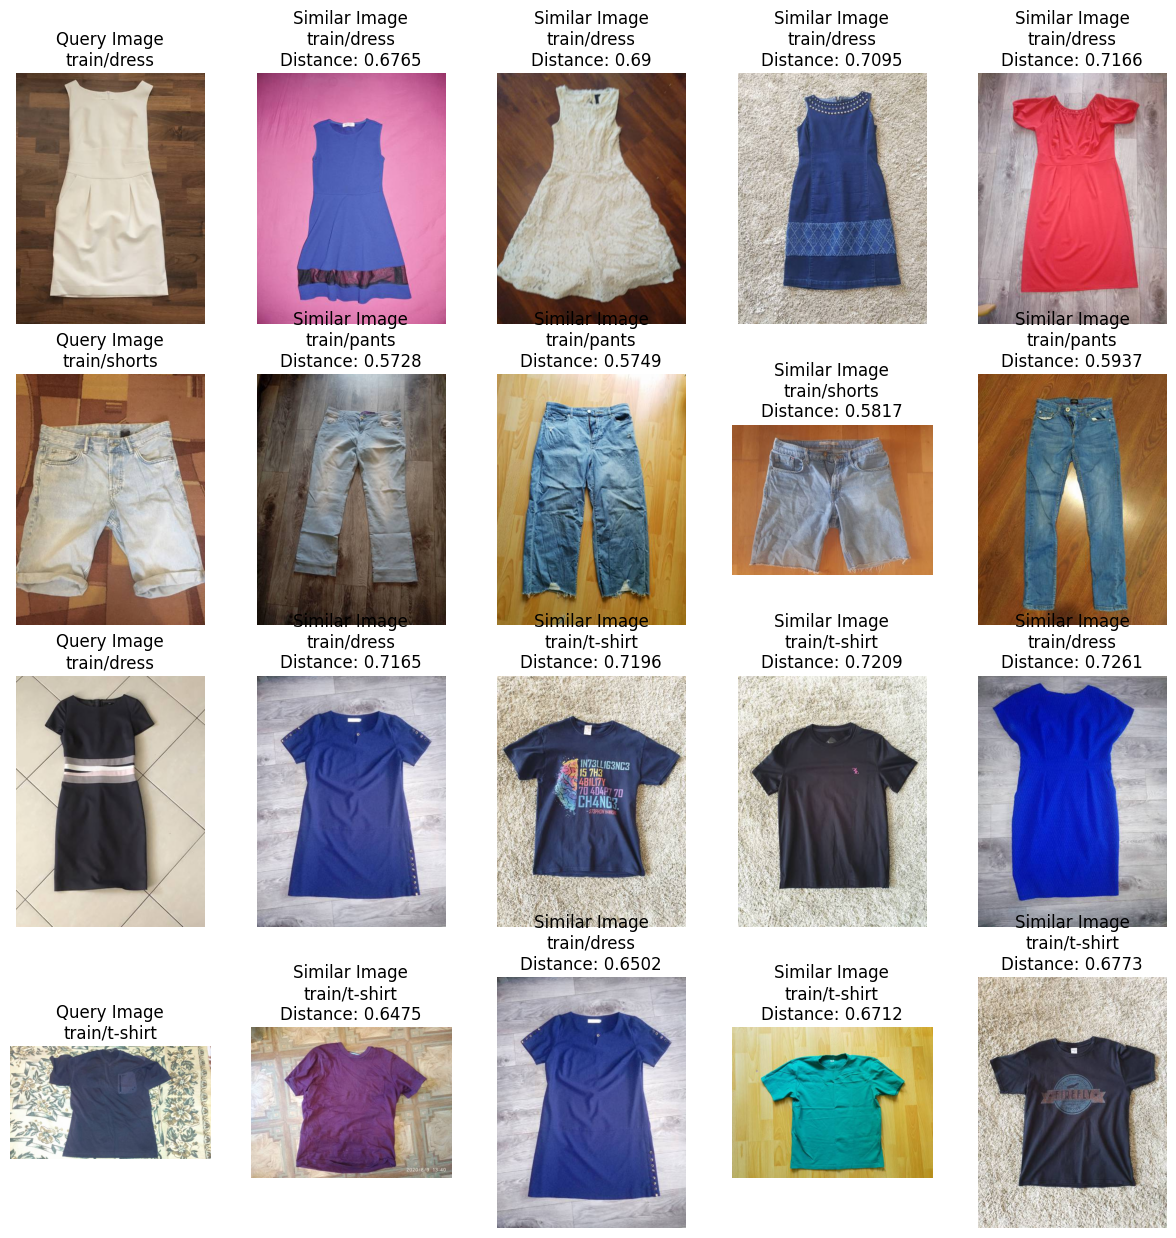

In [15]:
plot_images(filenames, feature_list, filenames, feature_list, 4, 4)

It seems, that model works quite good. Let's repeat the same calculations for the validation and test data. We use the same model to get features for validation and test data and save these features (and filenames):

In [16]:
save_to_pickle('data\\validation', base_model, 'pickles/val_features-fashion_small.pickle', 'pickles/val_filenames-fashion_small.pickle')
save_to_pickle('data\\test', base_model, 'pickles/test_features-fashion_small.pickle', 'pickles/test_filenames-fashion_small.pickle')

Then we load validation data set features and filenames and again plot 4 random images and 4 nearest neighbors of each image. This time we pick random images from validation dataset and their nearest neighbors in validation dataset:

In [17]:
# load validation data filenames and features:
val_filenames =  pickle.load(open('pickles/val_filenames-fashion_small.pickle', 'rb'))
val_feature_list = pickle.load(open('pickles/val_features-fashion_small.pickle', 'rb'))

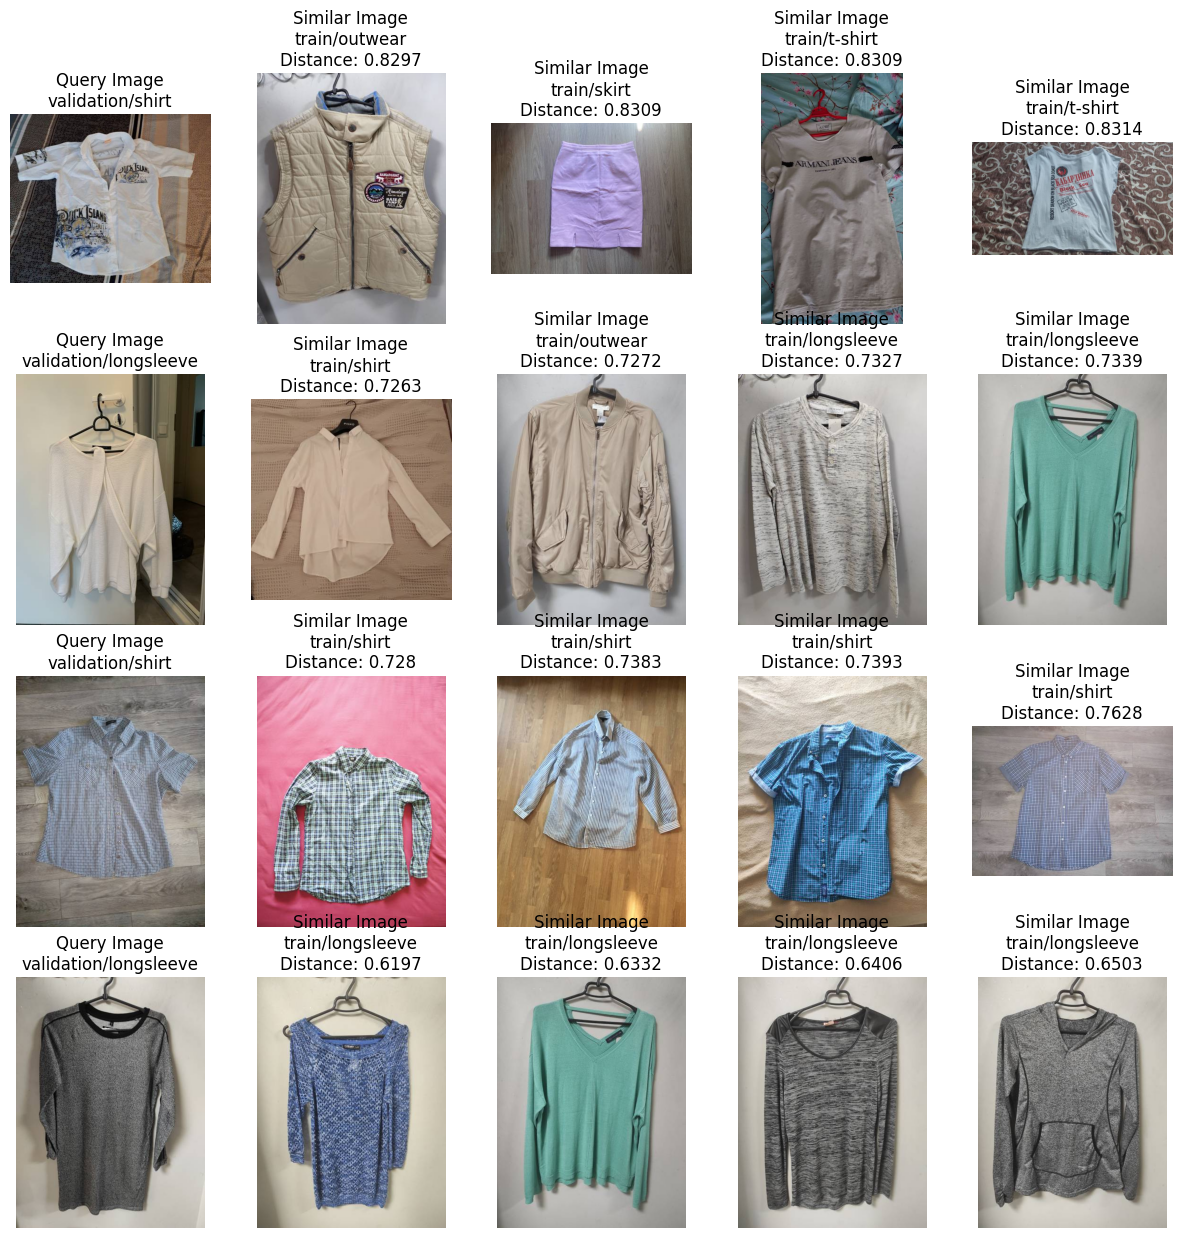

In [18]:
plot_images(val_filenames, val_feature_list, filenames, feature_list, 4, 4)

It looks that model works quite good on validation dataset as well. 
We need to check, how good our suggestions of similar images are. 
What is a good metric to check whether we are getting similar images?
There are two options:
1. Manually score whether the returned images look similar. In this case we have to go through the entire dataset for every image - it takes too long to do it.
2. We can simply calculate accuracy. In other words: are nearest neighbors of image belonging to category X also belonging to the same category? Moreover, if we take the mode of nearest neighbors categories for every image as "predicted" category, we can also calculate other metrics: precission, recall and F-1.

To do that, we first need to get categories of given images and their nearest neighbors. We set labels for train and validation data:

In [19]:
test_filenames =  pickle.load(open('pickles/test_filenames-fashion_small.pickle', 'rb'))
test_feature_list = pickle.load(open('pickles/test_features-fashion_small.pickle', 'rb'))

In [20]:
train_labels = [el.split("\\")[2] for el in filenames]
val_labels = [el.split("\\")[2] for el in val_filenames]

In [64]:
train_labels, val_labels

Encode the labels:

In [22]:
class_dict = {'dress':0 , 'hat':1, 'longsleeve':2, 'outwear':3, 'pants':4, 'shirt':5, 'shoes':6, 'shorts':7, 'skirt':8,'t-shirt':9}

label_encoder = LabelEncoder()
label_encoder.fit(list(class_dict.keys()))

train_labels_encoded = label_encoder.transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)

We also need to get categories of nearest neighbors of validation data:  

In [23]:
val_distances_list = []
val_indices_list = []
val_predicted_labels = []
val_predicted_labels_encoded = []
neighbors = knn.fit(feature_list)
for i in range(len(val_filenames)):
    val_distances, val_indices = neighbors.kneighbors([val_feature_list[i]])
    val_distances_list.append(val_distances.tolist()[0])
    val_indices_list.append(val_indices.tolist()[0])
    val_predicted_labels.append([train_labels[el] for el in val_indices_list[i]])
    val_predicted_labels_encoded.append([train_labels_encoded[el] for el in val_indices_list[i]])

So, for every validation data image we have list of the encoded nearest neighbors classes:

In [61]:
val_predicted_labels_encoded

We take y_true as encoded validation data labels.
We make a consumption that y_pred is the most common encoded nearest neighbors class for that image:

In [25]:
y_true = val_labels_encoded
y_pred = [statistics.mode(sublist) for sublist in val_predicted_labels_encoded]

For computing metrics and printing them as well as confusion matrix we define the print_scores function:

In [26]:
def print_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision_total = precision_score(y_true, y_pred, average='weighted')
    recall_total = recall_score(y_true, y_pred, average='weighted')
    f1_total = f1_score(y_true, y_pred, average='weighted')
    
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)

    # Print results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision_total))
    print("Recall: {:.4f}".format(recall_total))
    print("F1 Score: {:.4f}".format(f1_total))

    # Print results for each class
    for i in range(len(precision)):
        print("Class {}: Precision: {:.4f}, Recall: {:.4f}, F1 Score: {:.4f}".format(i, precision[i], recall[i], f1[i]))

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=list(class_dict.keys()))
    cm_display.plot(xticks_rotation=90)
    
    plt.show()

Now we can check the results on validation dataset:

Accuracy: 0.7889
Precision: 0.7929
Recall: 0.7889
F1 Score: 0.7850
Class 0: Precision: 0.8000, Recall: 0.5000, F1 Score: 0.6154
Class 1: Precision: 0.8571, Recall: 0.8571, F1 Score: 0.8571
Class 2: Precision: 0.6939, Recall: 0.6939, F1 Score: 0.6939
Class 3: Precision: 0.6957, Recall: 0.6667, F1 Score: 0.6809
Class 4: Precision: 0.8679, Recall: 0.9388, F1 Score: 0.9020
Class 5: Precision: 0.5556, Recall: 0.6897, F1 Score: 0.6154
Class 6: Precision: 1.0000, Recall: 0.9615, F1 Score: 0.9804
Class 7: Precision: 0.8421, Recall: 0.6400, F1 Score: 0.7273
Class 8: Precision: 0.7273, Recall: 0.6667, F1 Score: 0.6957
Class 9: Precision: 0.8352, Recall: 0.9383, F1 Score: 0.8837


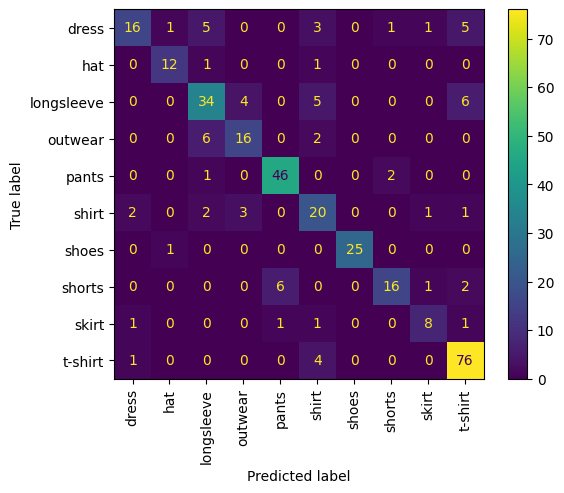

In [27]:
print_scores(y_true, y_pred)

As expected, they are quite good even with the pre-trained model. We can improve results with fine-tunning the model.

In [28]:
# save y_true and y_pred values to reuse them:
y_true_val = y_true
y_pred_val_pre_trained = y_pred

## Fine-tunning

A neural network has three parts:
* convolutional layers, which end up with the feature vectors;
* fully connected layers
* final classifier layer.

When we fine-tune a classification model, we usually leave convolutional layers, add new fully conncted layers to them and final classifier layer and then train this new model using our data set. This causes two things:

* The weights in all newly added fully connected layers will change significantly;
* The weights of the convolutional layers will change only slightly.

This is because the model tries to get the highest classification accuracy. Thus, the feature vectors will show only little change despite fine-tunning. 
Our goal is not to classify, but to achieve that similar looking images have closer features. So we need more changes in the weights of convolutional layers to adapt to our data set for the similarity searching task. To get this result, we need to remove all of the fully connected layers and add final classifier layer directly after convolutional layers.

We did fine-tunning in separate notebook and saved the fine-tuned model. We can load it and get feature vectors as we did earlier with pre-trained model:

In [29]:
model_fine_tuned = keras.models.load_model('model/transfer_learning/best_base_resnet_unfreezed.hdf5')
model_fine_tuned = Model(model_fine_tuned.input, model_fine_tuned.layers[-2].output)

Again, we save filename and feature vectors, load them, plot images and their nearest neighbors and calculate metrics of validation data to compare the results with pre-trained model: 

In [30]:
save_to_pickle('data\\train', model_fine_tuned, 'pickles/features-model_fine_tuned.pickle', 'pickles/filenames-model_fine_tuned.pickle')

In [31]:
# load saved filenames and features:
filenames = pickle.load(open('pickles/filenames-model_fine_tuned.pickle', 'rb'))
feature_list = pickle.load(open('pickles/features-model_fine_tuned.pickle', 'rb'))

# fit the knn model to get nearest neighbours and distances between features:
neighbors = knn.fit(feature_list)

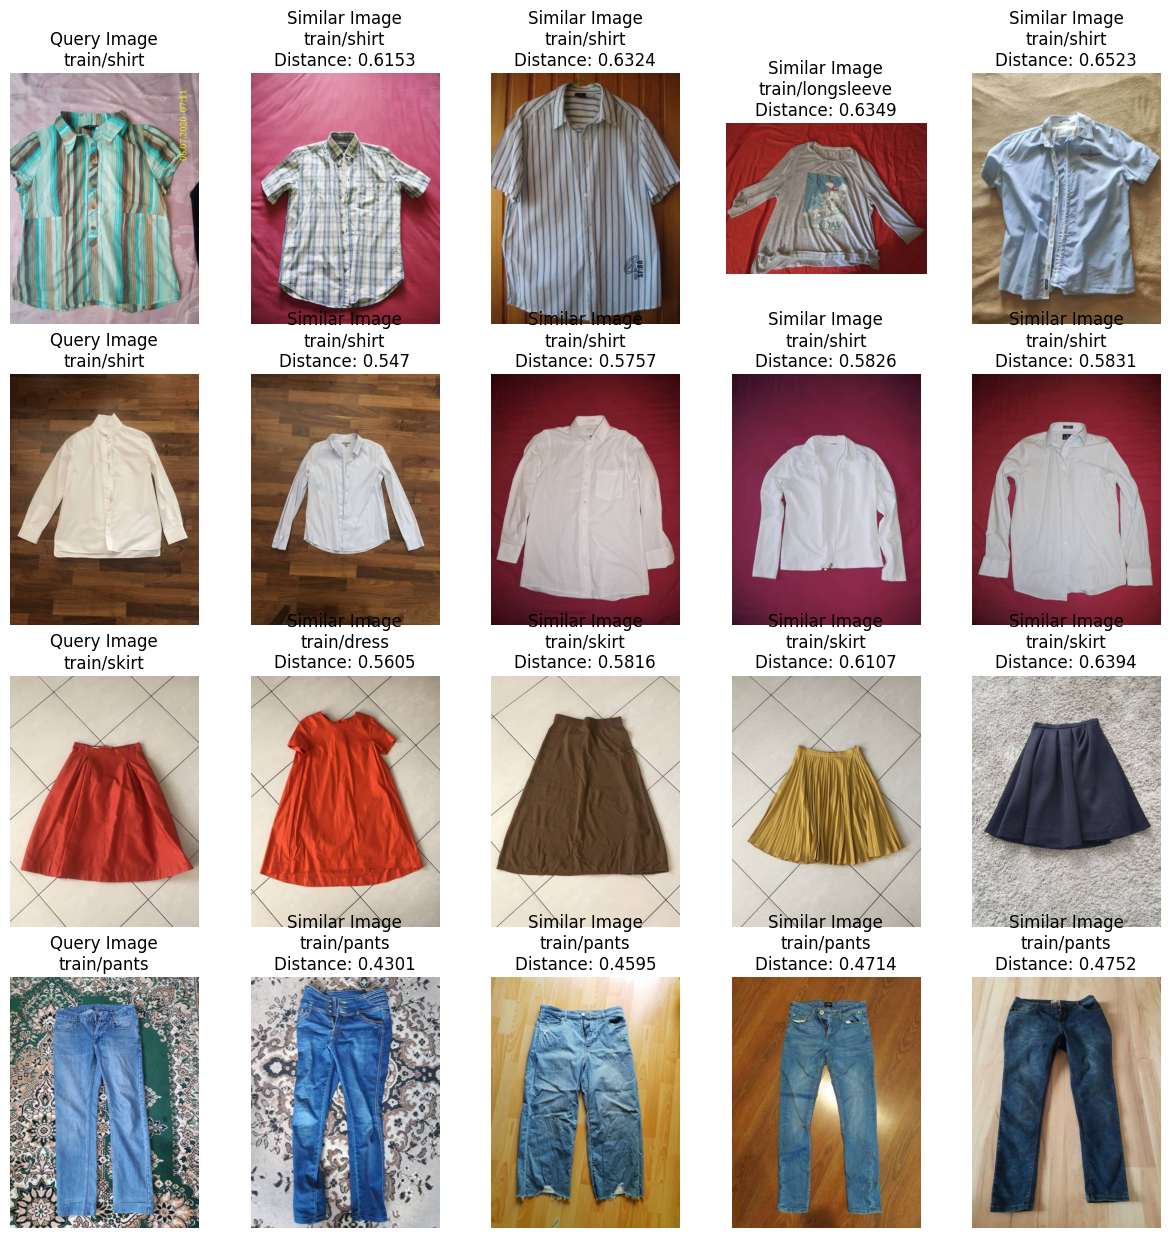

In [32]:
plot_images(filenames, feature_list, filenames, feature_list, 4, 4)

In [33]:
# we use the same model to get features for validation and test data and save them:
save_to_pickle('data\\validation', model_fine_tuned, 'pickles/val_features-model_fine_tuned.pickle', 'pickles/val_filenames-model_fine_tuned.pickle')
save_to_pickle('data\\test', model_fine_tuned, 'pickles/test_features-model_fine_tuned.pickle', 'pickles/test_filenames-model_fine_tuned.pickle')

In [34]:
# load validation data filenames and features:
val_filenames =  pickle.load(open('pickles/val_filenames-model_fine_tuned.pickle', 'rb'))
val_feature_list = pickle.load(open('pickles/val_features-model_fine_tuned.pickle', 'rb'))

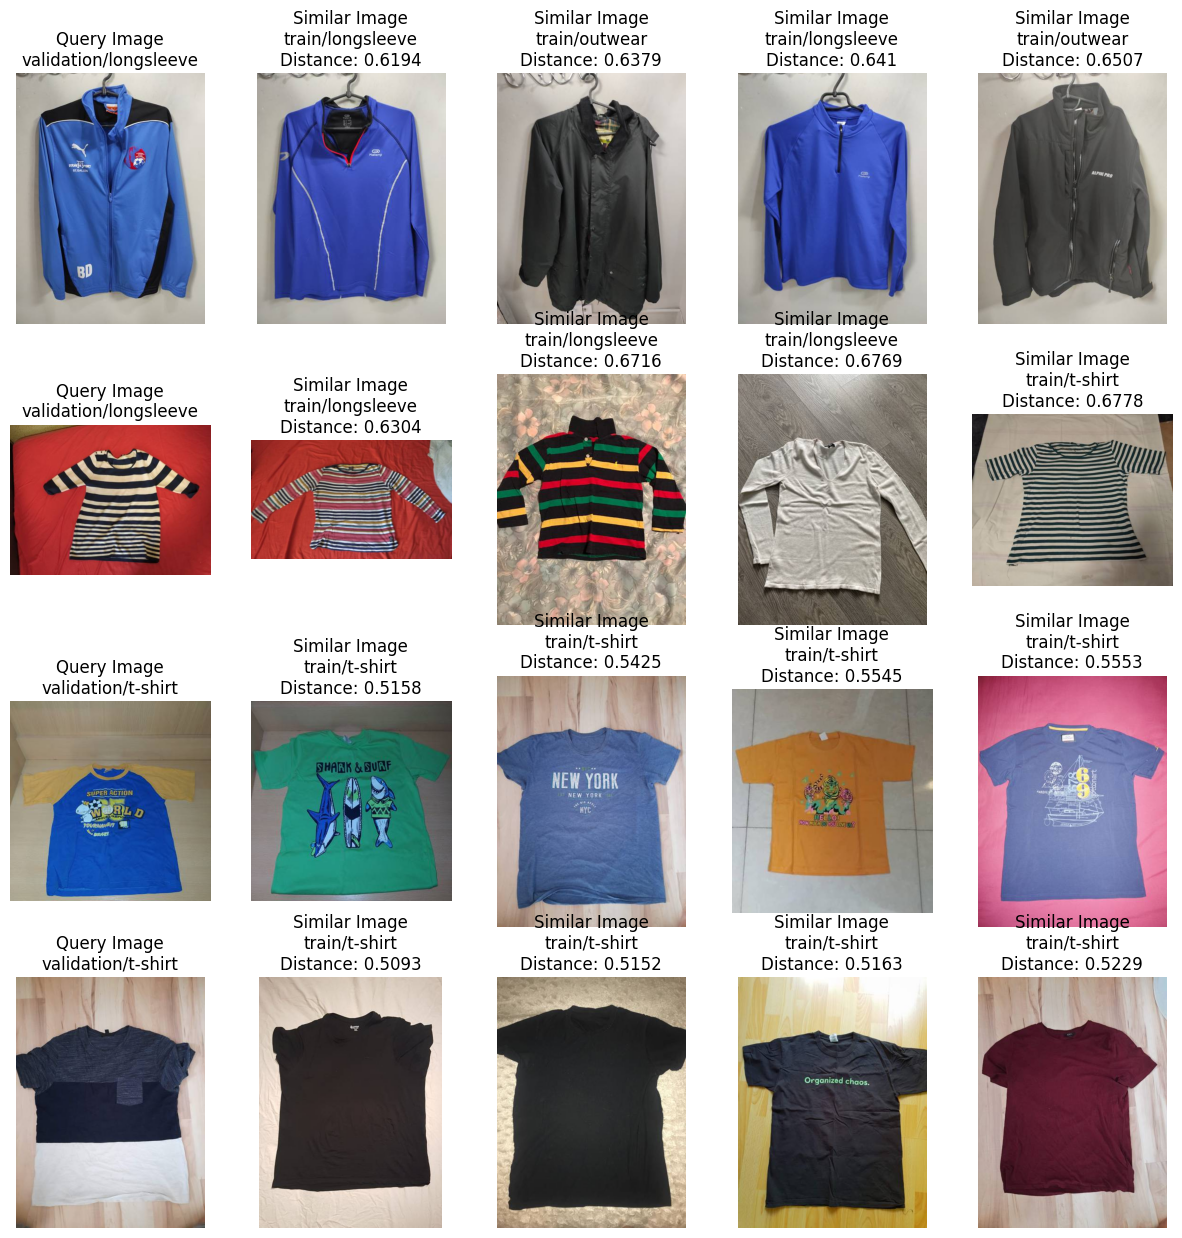

In [35]:
plot_images(val_filenames, val_feature_list, filenames, feature_list, 4, 4)

In [36]:
val_distances_list = []
val_indices_list = []
val_predicted_labels = []
val_predicted_labels_encoded = []
neighbors = knn.fit(feature_list)
for i in range(len(val_filenames)):
    val_distances, val_indices = neighbors.kneighbors([val_feature_list[i]])
    val_distances_list.append(val_distances.tolist()[0])
    val_indices_list.append(val_indices.tolist()[0])
    val_predicted_labels.append([train_labels[el] for el in val_indices_list[i]])
    val_predicted_labels_encoded.append([train_labels_encoded[el] for el in val_indices_list[i]])

In [37]:
# now we can compare true validation data images classes with their nearest neighbors classes and calculate metrics:
y_true = val_labels_encoded

# we make a consumption that Y_pred is the most common encoded nearest neighbors class for that image
y_pred = [statistics.mode(sublist) for sublist in val_predicted_labels_encoded]

Accuracy: 0.8680
Precision: 0.8729
Recall: 0.8680
F1 Score: 0.8658
Class 0: Precision: 0.9130, Recall: 0.6562, F1 Score: 0.7636
Class 1: Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 2: Precision: 0.7119, Recall: 0.8571, F1 Score: 0.7778
Class 3: Precision: 0.7778, Recall: 0.5833, F1 Score: 0.6667
Class 4: Precision: 0.9167, Recall: 0.8980, F1 Score: 0.9072
Class 5: Precision: 0.7812, Recall: 0.8621, F1 Score: 0.8197
Class 6: Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 7: Precision: 0.8333, Recall: 0.8000, F1 Score: 0.8163
Class 8: Precision: 1.0000, Recall: 0.8333, F1 Score: 0.9091
Class 9: Precision: 0.9195, Recall: 0.9877, F1 Score: 0.9524


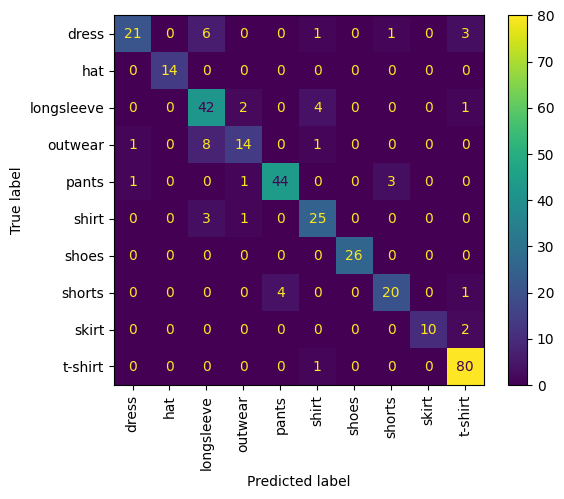

In [38]:
# print results for fine-tuned model:
print_scores(y_true, y_pred)

We improved the accuracy by almost 7%. 

In [39]:
# save y_pred values to reuse them:
y_pred_val_fine_tuned = y_pred

## Augmentations

Our data set is not big. Images are taken from above when the clothing was on a table, bed or floor. Therefore, we can make use of additional augmentations such as horizontal flip, random rotation, zoom range. 

The model training is in another notebook. We now load on augmented data pre-trained model and calculate the same metrics:

In [40]:
model_fine_tuned_augmented = keras.models.load_model('model/transfer_learning/best_base_resnet_unfreezed_augmented.hdf5')
model_fine_tuned_augmented = Model(model_fine_tuned_augmented.input, model_fine_tuned_augmented.layers[-2].output)

In [41]:
save_to_pickle('data\\train', model_fine_tuned_augmented, 'pickles/features-model_fine_tuned_augmented.pickle', 'pickles/filenames-model_fine_tuned_augmented.pickle')

In [42]:
# load saved filenames and features:
filenames = pickle.load(open('pickles/filenames-model_fine_tuned_augmented.pickle', 'rb'))
feature_list = pickle.load(open('pickles/features-model_fine_tuned_augmented.pickle', 'rb'))

# fit the knn model to get nearest neighbours and distances between features:
neighbors = knn.fit(feature_list)

In [43]:
# we use the same model to get features for validation and test data and save them:
save_to_pickle('data\\validation', model_fine_tuned_augmented, 'pickles/val_features-model_fine_tuned_augmented.pickle', 'pickles/val_filenames-model_fine_tuned_augmented.pickle')
save_to_pickle('data\\test', model_fine_tuned_augmented, 'pickles/test_features-model_fine_tuned_augmented.pickle', 'pickles/test_filenames-model_fine_tuned_augmented.pickle')

In [44]:
# load validation data filenames and features:
val_filenames =  pickle.load(open('pickles/val_filenames-model_fine_tuned_augmented.pickle', 'rb'))
val_feature_list = pickle.load(open('pickles/val_features-model_fine_tuned_augmented.pickle', 'rb'))

In [45]:
val_distances_list = []
val_indices_list = []
val_predicted_labels = []
val_predicted_labels_encoded = []
neighbors = knn.fit(feature_list)
for i in range(len(val_filenames)):
    val_distances, val_indices = neighbors.kneighbors([val_feature_list[i]])
    val_distances_list.append(val_distances.tolist()[0])
    val_indices_list.append(val_indices.tolist()[0])
    val_predicted_labels.append([train_labels[el] for el in val_indices_list[i]])
    val_predicted_labels_encoded.append([train_labels_encoded[el] for el in val_indices_list[i]])

In [46]:
# now we can compare true validation data images classes with their nearest neighbors classes and calculate metrics:
y_true = val_labels_encoded

# we make a consumption that Y_pred is the most common encoded nearest neighbors class for that image
y_pred = [statistics.mode(sublist) for sublist in val_predicted_labels_encoded]

Accuracy: 0.8886
Precision: 0.8921
Recall: 0.8886
F1 Score: 0.8869
Class 0: Precision: 0.9545, Recall: 0.6562, F1 Score: 0.7778
Class 1: Precision: 1.0000, Recall: 0.9286, F1 Score: 0.9630
Class 2: Precision: 0.7963, Recall: 0.8776, F1 Score: 0.8350
Class 3: Precision: 0.7600, Recall: 0.7917, F1 Score: 0.7755
Class 4: Precision: 0.9200, Recall: 0.9388, F1 Score: 0.9293
Class 5: Precision: 0.8519, Recall: 0.7931, F1 Score: 0.8214
Class 6: Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 7: Precision: 0.8148, Recall: 0.8800, F1 Score: 0.8462
Class 8: Precision: 0.9091, Recall: 0.8333, F1 Score: 0.8696
Class 9: Precision: 0.9302, Recall: 0.9877, F1 Score: 0.9581


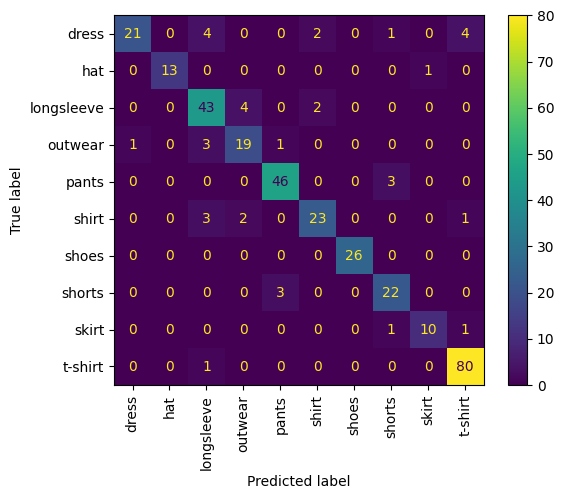

In [47]:
# print results for fine-tuned model:
print_scores(y_true, y_pred)

Augmentation improved accuracy of the model by 2%.

## Testing best model with test data

On the validation data we got the best results with the augmented data and fine-tuned model. We can see what results we get with the same hyperparameters on test data. Our train data now consists of train and validation data. We do all the same steps and finally print results for test data:

In [48]:
best_model_retrained = keras.models.load_model('model/transfer_learning/best_base_resnet_unfreezed_augmented_retrained.hdf5')
best_model_retrained = Model(best_model_retrained.input, best_model_retrained.layers[-2].output)

In [62]:
save_to_pickle('data\\train_val', best_model_retrained, 'pickles/features-best_model_retrained.pickle', 'pickles/filenames-best_model_retrained.pickle')

In [52]:
# load saved filenames and features:
filenames = pickle.load(open('pickles/filenames-best_model_retrained.pickle', 'rb'))
feature_list = pickle.load(open('pickles/features-best_model_retrained.pickle', 'rb'))

In [63]:
save_to_pickle('data\\test', best_model_retrained, 'pickles/test_features-best_model_retrained.pickle', 'pickles/test_filenames-best_model_retrained.pickle')

In [54]:
# load validation data filenames and features:
test_filenames =  pickle.load(open('pickles/test_filenames-best_model_retrained.pickle', 'rb'))
test_feature_list = pickle.load(open('pickles/test_features-best_model_retrained.pickle', 'rb'))

In [55]:
train_val_labels = [el.split("\\")[2] for el in filenames]
test_labels = [el.split("\\")[2] for el in test_filenames]

train_val_labels_encoded = label_encoder.transform(train_val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [56]:
test_distances_list = []
test_indices_list = []
test_predicted_labels = []
test_predicted_labels_encoded = []
neighbors = knn.fit(feature_list)
for i in range(len(test_filenames)):
    test_distances, test_indices = neighbors.kneighbors([test_feature_list[i]])
    test_distances_list.append(test_distances.tolist()[0])
    test_indices_list.append(test_indices.tolist()[0])
    test_predicted_labels.append([train_val_labels[el] for el in test_indices_list[i]])
    test_predicted_labels_encoded.append([train_val_labels_encoded[el] for el in test_indices_list[i]])

In [57]:
# now we can compare true test data images classes with their nearest neighbors classes and calculate metrics:
y_true = test_labels_encoded

# we make a consumption that Y_pred is the most common encoded nearest neighbors class for that image
y_pred = [statistics.mode(sublist) for sublist in test_predicted_labels_encoded]

Accuracy: 0.8710
Precision: 0.8771
Recall: 0.8710
F1 Score: 0.8718
Class 0: Precision: 0.7692, Recall: 0.6667, F1 Score: 0.7143
Class 1: Precision: 1.0000, Recall: 0.8333, F1 Score: 0.9091
Class 2: Precision: 0.8088, Recall: 0.7639, F1 Score: 0.7857
Class 3: Precision: 0.8788, Recall: 0.7632, F1 Score: 0.8169
Class 4: Precision: 0.9333, Recall: 1.0000, F1 Score: 0.9655
Class 5: Precision: 0.6000, Recall: 0.8077, F1 Score: 0.6885
Class 6: Precision: 1.0000, Recall: 0.9863, F1 Score: 0.9931
Class 7: Precision: 0.9310, Recall: 0.9000, F1 Score: 0.9153
Class 8: Precision: 0.8333, Recall: 0.8333, F1 Score: 0.8333
Class 9: Precision: 0.8727, Recall: 0.9231, F1 Score: 0.8972


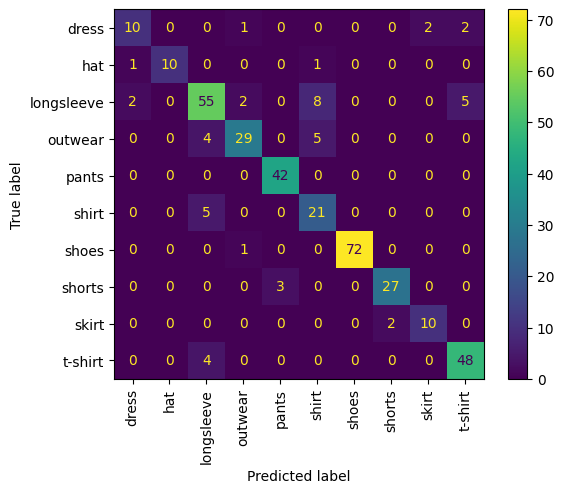

In [58]:
print_scores(y_true, y_pred)

Our model works good with the test data as well.

## Reducing Feature-Length

We have feature vectors of length 2048. In this study we have not so many images. In real life it could be million or even more images. It would be really slow to search for similar images with such long features. We can make the search faster either reducing length of feature vectors or using better(faster) algorithm to search among long feature vectors.

One of the ways to reduce feature vector length is to use Principal Component Analysis. In it we generate new set of features that are a linear combination of the input features and they are orthogonal to one another. These new features are called principal components.

In [295]:
num_feature_dimensions=100
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

We can also get relative importance of each feature. 

In [296]:
# Explain the importance of first 20 features
print(pca.explained_variance_ratio_[0:20])

[0.15731265 0.08497907 0.06618998 0.05182134 0.02863841 0.0239555
 0.02178966 0.01993979 0.01765224 0.01688953 0.01544509 0.01375695
 0.01302802 0.01244413 0.01114901 0.01033594 0.0094969  0.00895915
 0.00877821 0.00816792]


How to choose the size of dimensions? As we see, importance of features are getting lower and even the 20th feature's explained variance ratio is less then 0.01. Let's plot the importance of first 200 dimensions:

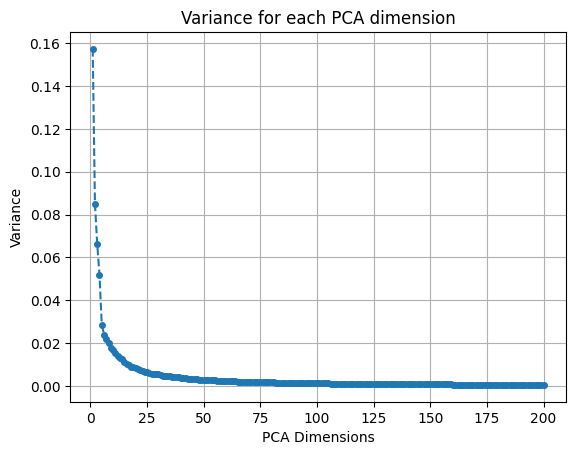

In [297]:
pca = PCA(200)
pca.fit(feature_list)
plt.plot(range(1,201),pca.explained_variance_ratio_,'o--', markersize=4)
plt.title ('Variance for each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

We can see that every dimension after the first 100 dimensions adds variance almost equal to 0. So we can use PCA with 100 dimensions instead of original 2048 length feature vectors to get quite similar results.

We can also plot cumulative variance vs number of PCA dimensions: 

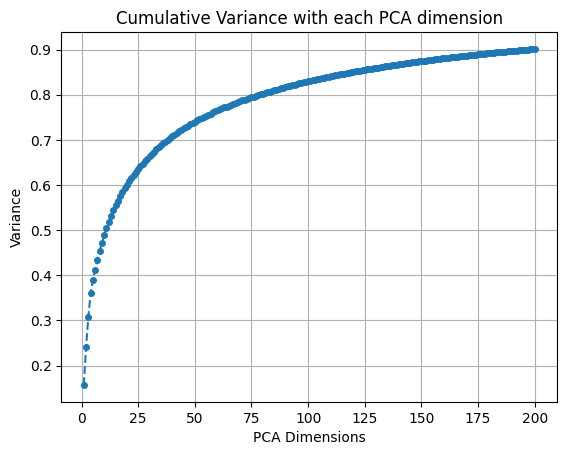

In [299]:
plt.plot(range(1,201),pca.explained_variance_ratio_.cumsum(),'o--', markersize=4)
plt.title ('Cumulative Variance with each PCA dimension')
plt.xlabel('PCA Dimensions')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

If we plot it to 2048, our cumulative variance would be 1. 

Depending on the problem and data set, we can find optimal PCA dimensions number to get good balance between accuracy and speed. 

## Notes

In this study we also check how different distance metrics work on our features. To do it, just change the metric value in the Chapter 2. :

__knn = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')__ 

and re-run the notebook. Results with cosine distance are almost the same, so we left calculations only with Euclidean distance.